In [3]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from braincoder.utils.visualize import *
%matplotlib inline

import tensorflow as tf
tf.config.list_physical_devices('GPU')

    

[]

In [4]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))
y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)
n_vx = 100
bounds = {
    'x' : [-1, 1],
    'y' : [-.5, .5],
    'sd' : [0.01, 2],
    'baseline' : [-1,1],
    'amplitude' : [0, 5], 
}
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

idx_cols = sns.color_palette("hsv", n_vx)

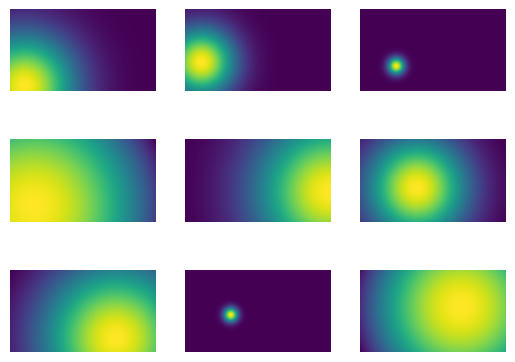

In [5]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

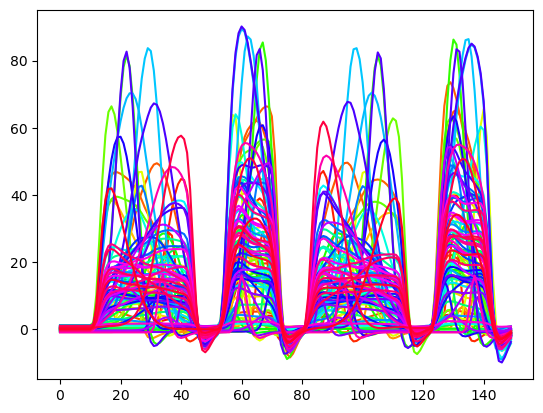

In [6]:
pred = model.predict()
for i in range(n_vx):
    plt.plot(
        pred.iloc[:,i],
        color=idx_cols[i]
    )

## Noisy predictions

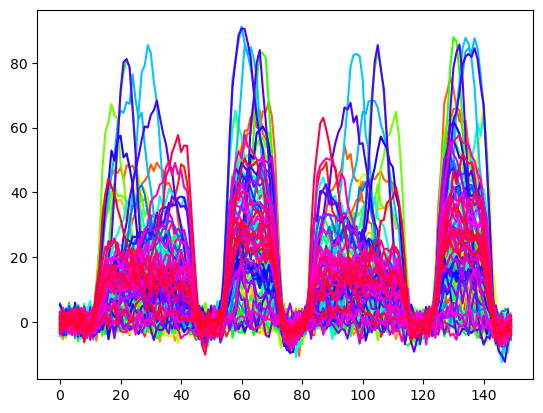

In [7]:
data = model.simulate(noise=2)
for i in range(n_vx):
    plt.plot(
        data.iloc[:,i],
        color=idx_cols[i]
    )

# Estimate parameters

In [8]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)

Working with chunk size of 7407
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: 0.83492/Best R2: 0.83492: 100%|██████████| 1000/1000 [00:30<00:00, 32.41it/s]


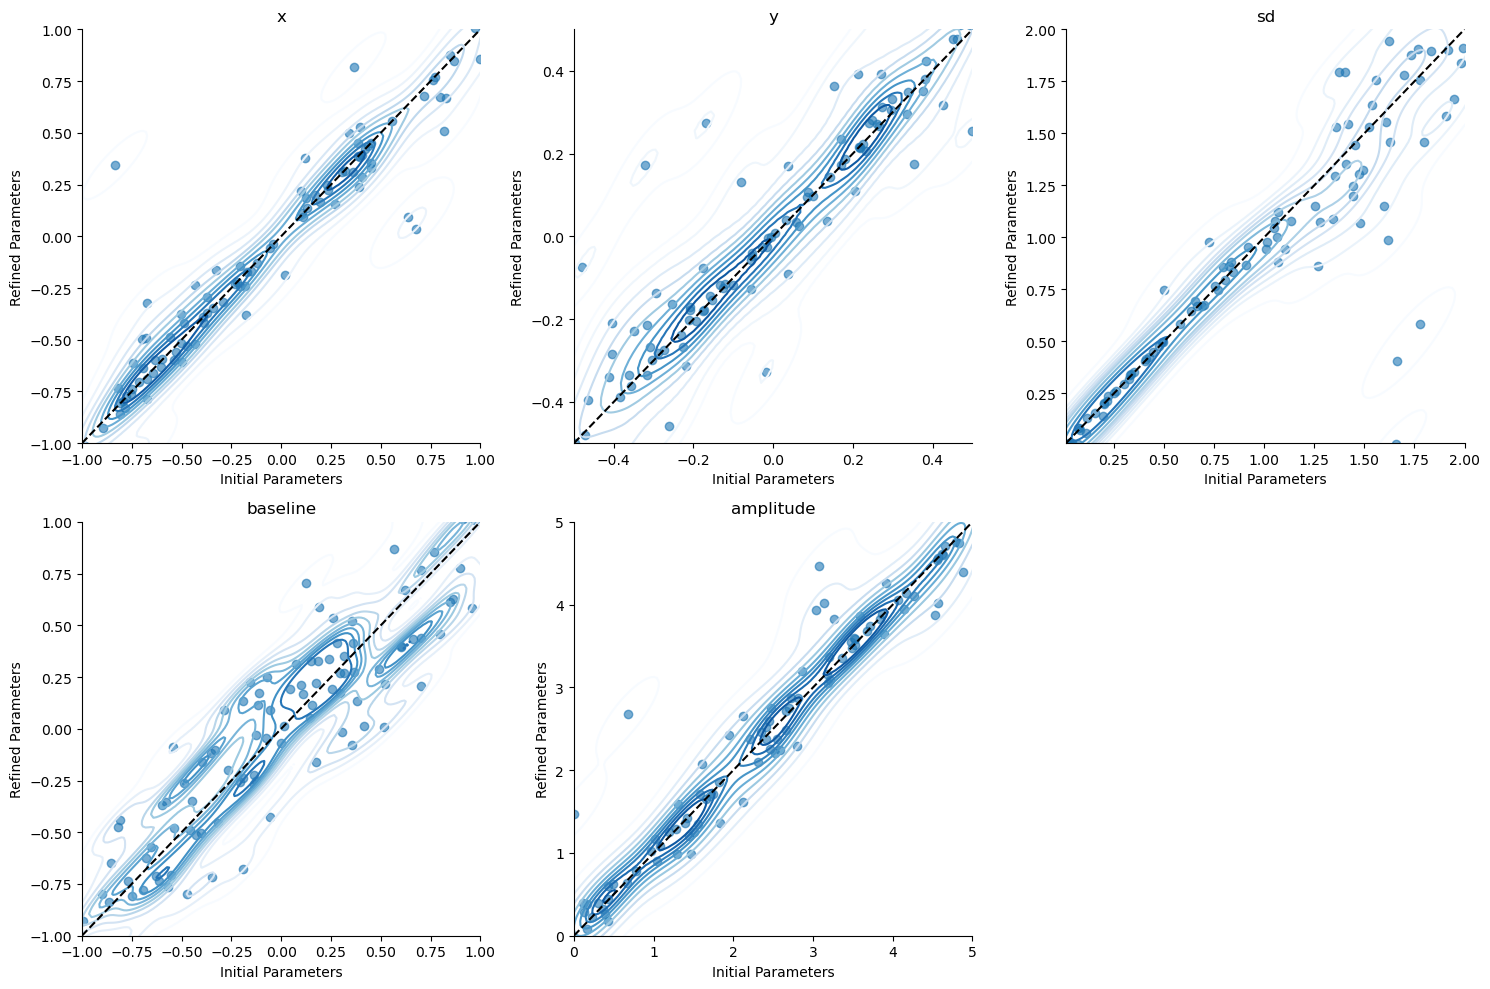

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
param_names = parameters.columns

for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(parameters[param], refined_pars[param], alpha=0.6)
    sns.kdeplot(x=parameters[param], y=refined_pars[param], ax=ax, cmap="Blues", bw_adjust=0.5)
    ax.set_title(param)
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
sns.despine()
axs[-1].set_axis_off()
plt.tight_layout()
plt.show()

parameter
x            0.873835
y            0.095214
sd           0.496147
baseline     0.249739
amplitude    2.866224
Name: 99, dtype: float32
x            0.845946
y            0.085037
sd           0.487382
baseline    -0.073515
amplitude    2.815874
Name: 99, dtype: float32


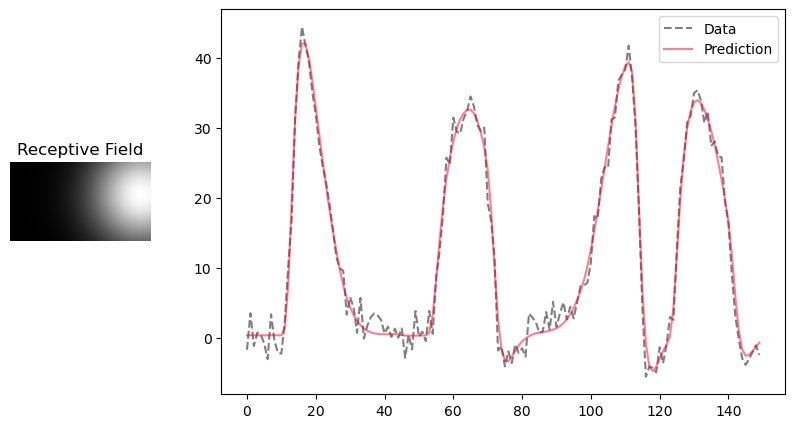

In [11]:
idx = -1
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx],
    color=idx_cols[idx]

)
print(refined_pars.iloc[idx,:])
print(parameters.iloc[idx,:])

# MCMC Gaussian

In [12]:
n_vx = parameters.shape[0]
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),
})


num_results = 100
tf.random.set_seed(1)
# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )
bfitter.prep_for_fitting()

# Fit all vx at once... may not be the best way but doing it for now...
bfitter.fit_all(
    init_pars=init_pars,
    num_results=num_results,
)


Lets run some checks with everything...


In [2]:
# Lets see are we getting closer?
fig,axs = plt.subplots(3,2,figsize=(15,10))
axs = axs.flatten()
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    for i in range(1):
        ax.plot(
            bfitter.mcmc_sampler[i][p],
            color=idx_cols[i],        
            )
        # Lets add the ground truth
        ax.axhline(
            parameters[p][i], 
            color=idx_cols[i],        
            linestyle=':'
        )

ax = axs[-1]
ax.set_title('Rsq')
for i in range(9):
    rsq = bfitter.get_rsq_for_idx(
        idx=i, parameters=bfitter.mcmc_sampler[i],
    )
    plt.plot(
        rsq, 
        color=idx_cols[i]
        ) 
plt.ylim(0,1)
plt.tight_layout()

NameError: name 'plt' is not defined

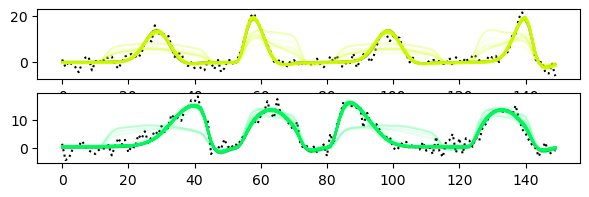

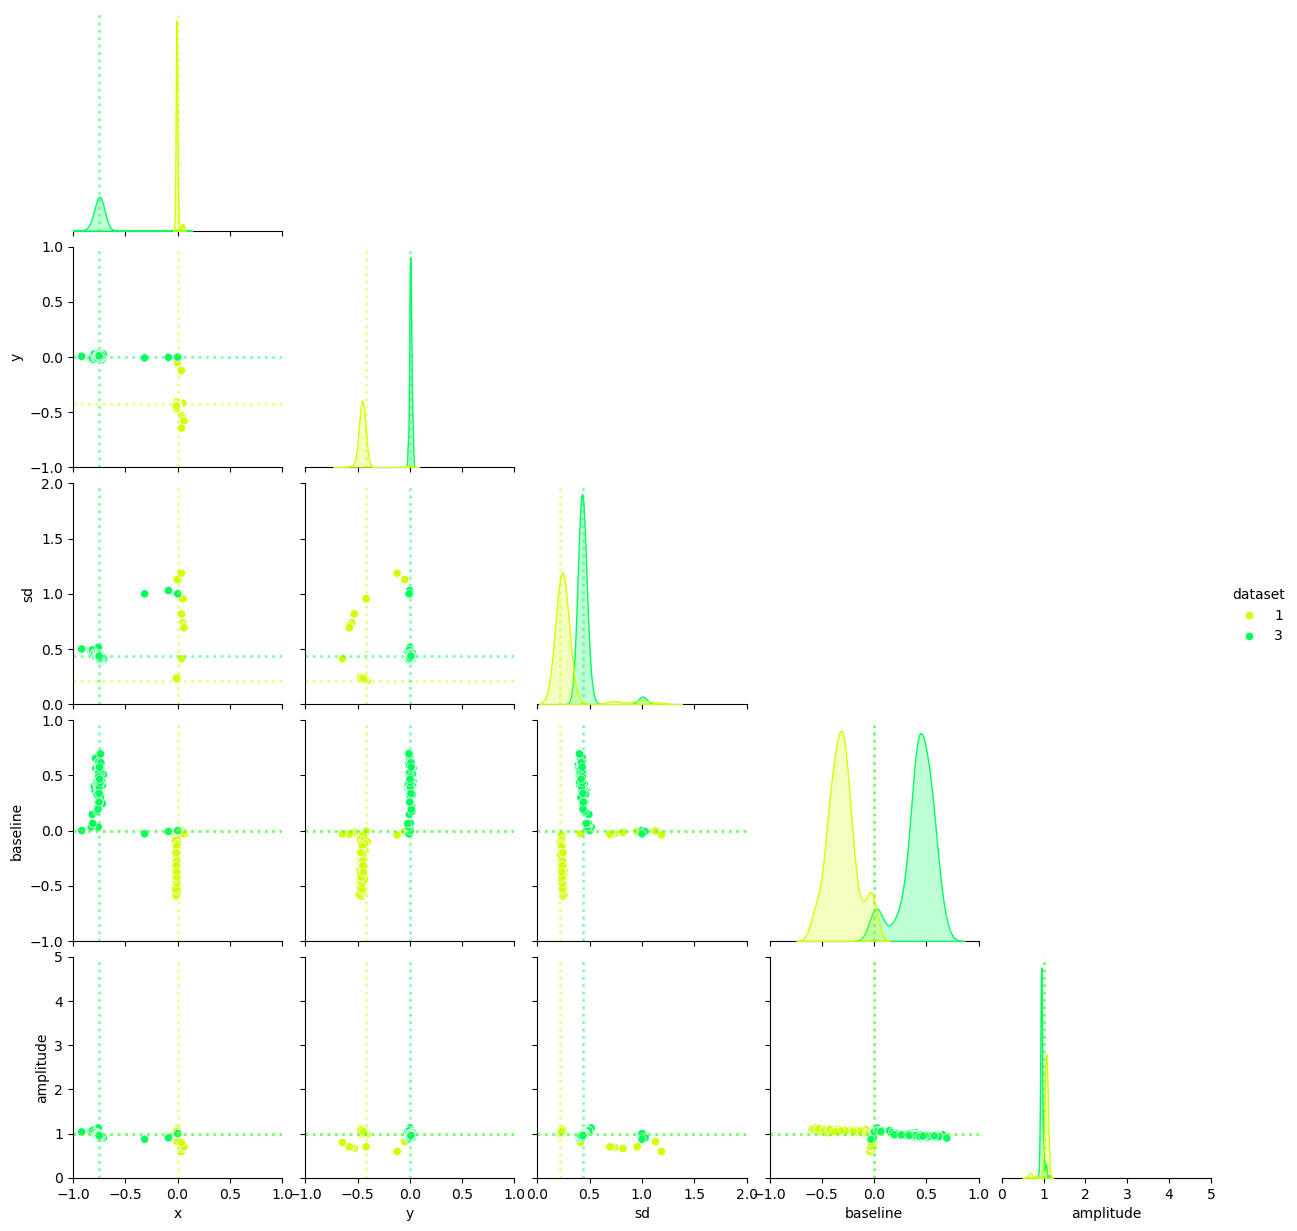

In [49]:
# Which fits to compare 
idx_list = [1, 3]
burn_in = 0 # exclude first 'n' 

# Lets look at the data and fits
fig, axs = plt.subplots(2,1, figsize=(7,2))
for iplot,idx in enumerate(idx_list):
    axs[iplot].plot(data.iloc[:,idx], ':k')
    # Plot the 'best' fit from classical fitter
    axs[iplot].plot(pred.iloc[:,idx], '-k', alpha=0.4)
    this_preds = bfitter.model.predict(
        parameters=bfitter.mcmc_sampler[idx].iloc[burn_in:,:]
        )
    axs[iplot].plot(
        this_preds, color=idx_cols[idx], alpha=0.1
    )

combined_data = pd.concat(
    [bfitter.mcmc_sampler[i].iloc[burn_in:, :].assign(dataset=i) for i in idx_list],
    ignore_index=True
)

sns_plot = sns.pairplot(
    combined_data,
    # diag_kind='kde',
    corner=True,
    hue='dataset',  # Use the 'dataset' column for coloring
    palette=[idx_cols[i] for i in idx_list],  # Optional: choose a color palette
)
for i in idx_list:
    edit_pair_plot(
        sns_plot.axes, 
        lines_dict=parameters.iloc[i,:].to_dict(), 
        color=idx_cols[i], 
        linestyle=':', lw=2, alpha=.5,
        lim_dict=bounds,
    )    

# Mexican hat model -> not done yet...

In [50]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

(1, 9, 7) (1, 9, 5)


<Axes: xlabel='frame'>

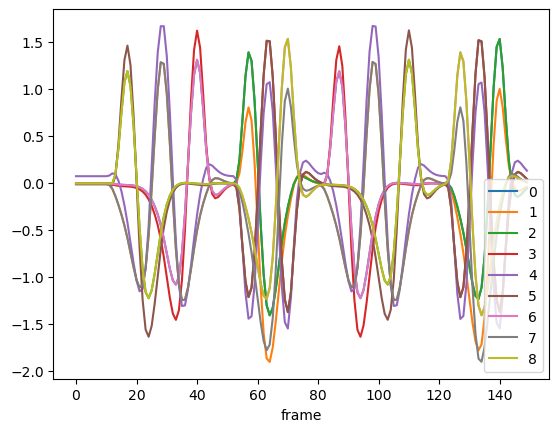

In [51]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.3,
               'baseline':0.0,
               'srf_amplitude':.4, 
               'srf_size':2}).astype(np.float32)
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))
pred_dog = model_dog.predict()
pred_dog.plot()

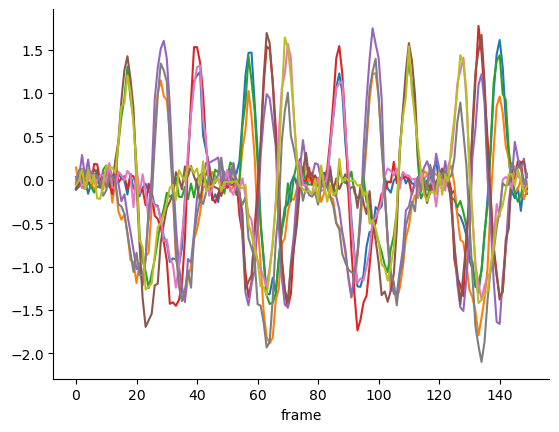

In [52]:
data_dog = model_dog.simulate(noise=.1)
data_dog.plot(legend=False)
sns.despine()

In [53]:
fitter_dog = ParameterFitter(model_dog, data_dog, paradigm)

In [54]:
init_pars_dog = refined_pars.copy()
init_pars_dog['srf_amplitude'] = 0.1
init_pars_dog['srf_size'] = 2.

In [55]:
est_pars_dog = fitter_dog.fit(
    init_pars=init_pars_dog, learning_rate=0.001,
    max_n_iterations=5000,
    )

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.42749/Best R2: 0.42749: 100%|██████████| 5000/5000 [01:07<00:00, 74.55it/s]   


parameter
x               -0.752158
y               -0.636698
sd               0.072545
baseline        -0.218025
amplitude        0.939081
srf_amplitude    0.076362
srf_size         1.449454
Name: 0, dtype: float32
x               -0.750000
y               -0.421875
sd               0.200000
amplitude        0.300000
baseline         0.000000
srf_amplitude    0.400000
srf_size         2.000000
Name: 0, dtype: float32


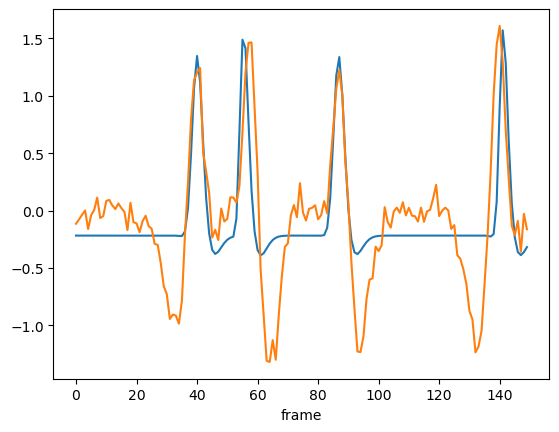

In [56]:
idx = 0
est_pred = model_dog.predict(parameters=est_pars_dog)
est_pred[idx].plot()
data_dog[idx].plot()
print(est_pars_dog.iloc[idx,:])
print(parameters_dog.iloc[idx,:])


# MCMC - DOG

In [59]:
bounds_dog = {
    'x' : [-1, 1],
    'y' : [-1, 1],
    'sd' : [0, 2],
    'baseline' : [-1,1],
    'amplitude' : [0, 5],  
    'srf_amplitude': [0, 10],
    'srf_size' : [1, 10],

}

n_vx = parameters_dog.shape[0]
init_pars_dog = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.zeros(n_vx)+1,
    'baseline' : np.zeros(n_vx),
    'amplitude' : np.zeros(n_vx) + 1,
    'srf_amplitude' : np.zeros(n_vx) + .5,
    'srf_size' : np.zeros(n_vx) + 2,

})
bfitter_dog = BPRF(model=model_dog, data=data_dog, )
bfitter_dog.add_priors_from_bounds(bounds_dog, )
bfitter_dog.prep_for_fitting()

In [62]:
bfitter_dog.fit_all(
    init_pars=init_pars_dog,
    num_results=5,         
)

Lets run some checks with everything...
(1, 9, 7) (1, 9, 5)


In [ ]:
idx = 0
burn_in = 0

rsq = bfitter_dog.get_rsq_for_idx(
    idx=idx, parameters=bfitter_dog.mcmc_sampler[idx],
)
plt.plot(rsq)
plt.figure()
rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

sns_plot = sns.pairplot(
    bfitter_dog.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
edit_pair_plot(
    sns_plot.axes, lines_dict=parameters_dog.iloc[idx,:].to_dict(), color='g', linestyle=':'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.show()

In [ ]:
plt.plot(
    bfitter_dog.mcmc_sampler[idx].x
)

In [ ]:
bfitter_dog.mcmc_sampler[idx].shape

In [ ]:
bfitter_dog.mcmc_sampler[0].x